# Cohort Construction and Model Development Pipeline

In [ ]:
import pandas as pd
import numpy as np
import HelperFunctions as Helper
import DiseaseGroup as DG
from math import floor
import time
import pickle
from scipy.stats import loguniform
from tqdm import tqdm
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import nannyml as nml
colors =  nml.plots.colors.Colors
# SKLEARN
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
# METRICS
# Classification
from sklearn.metrics import average_precision_score, f1_score, recall_score, precision_score, classification_report
# Risk Prediction
from sklearn.metrics import brier_score_loss
# IMBLEARN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imb_Pipeline
# MODEL ARCHITECTURES
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## Cohort construction

Define disease group of interest and data processing methods

In [ ]:
# Set cohort construction and model development parameters
Group = 'Diabetes'
Filter = ''
Normalize = False

OuterFolds = 5
InnerFolds = 3
    
random_state = 8

In [ ]:
GroupDict = {
    'CVD' : {
        'Group':DG.CVD(kind='base'),
        'Filter':[]},
    'CVD_nonHyper' : {
        'Group':DG.CVD(kind='base'),
        'Filter':DG.CVD(kind='hyper')},
    'Skin' : {
        'Group':DG.SkinCancer(kind='all'),
        'Filter':[]}, 
    'Skin_malignant' : {
        'Group':DG.SkinCancer(kind='malignant'),
        'Filter':DG.SkinCancer(kind='benign')},
    'Diabetes' : {
        'Group':DG.Diabetes(),
        'Filter':[]}      
    }

Load participant characteristics

In [ ]:
ROOT = 'Data'
# Participants who only attended the second round
exclusion = [1827224, 2183585, 3718151, 5721114]

# Assessment dates data (ordered chronologically)
df_assess = pd.read_csv(f'{ROOT}/f.53.tab', delimiter='\t')
df_assess = df_assess.set_index('f.eid').drop(index=exclusion)

# Drop imaging visits
df_assess = df_assess.dropna(axis=0, how='all').drop(['f.53.2.0', 'f.53.3.0'], axis=1)
for col in df_assess.columns:
        df_assess[col] = pd.to_datetime(df_assess[col])

# Dates of all participants first visit
df_visit0 = df_assess.drop(['f.53.1.0'], axis=1).copy().rename(columns={'f.53.0.0':'Visit 0'})
# Dates of two-assessment participants second visit
df_visit1 = df_assess.drop(['f.53.0.0'], axis=1).copy().dropna().rename(columns={'f.53.1.0':'Visit 1'})
# Remove two-assessment participants from df_visit1
df_visit0 = Helper.dfRelComp(df_visit0, df_visit1)
# Dates of all visits for two-assessment participants
df_both = df_assess.dropna().rename(columns={'f.53.0.0':'Visit 0','f.53.1.0':'Visit 1'})

# ICD-10 encodings
df_codes = pd.read_csv(f'{ROOT}/f.41270.tab', delimiter='\t', low_memory=False)
df_dates = pd.read_csv(f'{ROOT}/f.41280.tab', delimiter='\t', low_memory=False)


Identify traceability cohort (participants in the second assessment session)

In [ ]:
Type = Group+Filter

ICDs = GroupDict[Type]['Group']
# Designate which other diagnoses should be washed from the study
## If there are no ICDs to exclude then assign the empty list
WashICDs = GroupDict[Type]['Filter']
# Choose a cutoff threshold from 2 - 6 years
years = 5
cutoff_variable = np.timedelta64(365*years + floor(years/4),'D')

# Number of diagnosis columns
colRange = range(213)

# Stack df_visit1 with df_visit2
df_stack = df_assess.copy().rename(columns={'f.53.0.0': 'Visit 0', 'f.53.1.0': 'Visit 1'})    

# Add washout period
df_stack['Wash 0'] = df_stack['Visit 0'] + np.timedelta64(365,'D')
df_stack['Wash 1'] = df_stack['Visit 1'] + np.timedelta64(365,'D')
# Add cutoff date
df_stack['Cutoff 0'] = df_stack['Visit 0'] + cutoff_variable
df_stack['Cutoff 1'] = df_stack['Visit 1'] + cutoff_variable

# All potential training candidates
positiveTrain = Helper.positiveClass(df=df_codes, ICDs=ICDs, colRange=colRange)
# All candidates with an undesiarable diagnosis
washClass = Helper.positiveClass(df=df_codes, ICDs=WashICDs, colRange=colRange)
# Filter using washClass
positiveTrain.difference_update(washClass)
# Extract validation candidates
positiveTrace = positiveTrain.intersection(set(df_visit1.index))
# Remove validation from training
positiveTrain.difference_update(positiveTrace)

# Construct cohorts
trainPosClass, movers, tracePosClass, washDict = Helper.positiveCohortSplit(ICDs=ICDs, positiveTrain=positiveTrain, df_codes=df_codes, df_dates=df_dates,
                                                                df_Main=df_stack, positiveVal=positiveTrace, cutoff=True, exclusive=False)

indexPosTrain = set(trainPosClass.index)
indexPosTrace = set(tracePosClass.index)
# Pull f.eid of single and double participants (train and validation candidates)
indexSingleVisit = set(df_visit0.index)
indexDoubleVisit = set(df_visit1.index)

# Filter all participants with any diagnosis
df_healthy = df_codes.drop('Iid', axis=1).set_index('f.eid')
df_healthy = df_healthy[df_healthy.isna().all(axis=1)]
indexHealthy = set(df_healthy.index)

# Pull f.eid of all single and double participants with no diagnoses
# These consitute our negative class training and traceability set respectively
indexNegTrain = indexSingleVisit.intersection(indexHealthy)
indexNegTrace = indexDoubleVisit.intersection(indexHealthy)

Select an external test set (participants from select geographically distant assessment centers)

In [ ]:
df_loc = pd.read_csv(f'{ROOT}/f.54.tab', sep='\t').set_index('f.eid').drop(['f.54.2.0','f.54.3.0'], axis=1)
df_loc = df_loc.drop('f.54.1.0', axis=1).rename(columns={'f.54.0.0':'Center'}).dropna()

# Filter for those who qualify for training set
df_loc = df_loc[df_loc.index.isin(indexPosTrain.union(indexNegTrain))]

# Manchester, Oxford, Glasgow, Cardiff
externalSplit = {'Manchester':11001,
                 'Oxford':11002,
                 'Glasgow':11004,
                 'Cardiff':11003}

extDict = dict()
for loc in externalSplit.keys():
    locIndex = df_loc.loc[df_loc['Center']==externalSplit[loc]].index

    indexNegExt = indexNegTrain.intersection(locIndex)
    indexNegTrain.difference_update(locIndex)
    indexPosExt = indexPosTrain.intersection(locIndex)
    indexPosTrain.difference_update(locIndex)

    extDict[loc] = {'Neg':indexNegExt.copy(),
                    'Pos':indexPosExt.copy()}

indexNegExt = set()
indexPosExt = set()
for loc in extDict.keys():
    indexNegExt = indexNegExt.union(extDict[loc]['Neg'])
    indexPosExt = indexPosExt.union(extDict[loc]['Pos'])

Load raw exposome data

In [ ]:
# Exposome data
df_expo = pd.read_csv(f'{ROOT}/x_nan_d.csv')
df_expo = df_expo.set_index('f.eid')
df_expo = df_expo.rename(columns={"age":"birthyear"})
df_expo2 = pd.read_csv(f'{ROOT}/x_nan_d_2.csv')
df_expo2 = df_expo2.set_index('f.eid')
df_expo2 = df_expo2.rename(columns={"age":"birthyear"})

# Store feature names and rename expo and expo2 columns
featureDict = dict()
for i,col in enumerate(df_expo.columns):
    featureDict[f'f{i}'] = col

with open(f'featureDict', 'wb') as fp:
    pickle.dump(featureDict, fp)

renameMap = dict(map(reversed, featureDict.items()))

df_expo = df_expo.rename(columns=renameMap)
df_expo2 = df_expo2.rename(columns=renameMap)

# Training cohort construction
# negative members
negTrain = df_expo[df_expo.index.isin(indexNegTrain)].copy()
negTrain['target'] = 0
#positive members
posTrain = df_expo[df_expo.index.isin(indexPosTrain)].copy()
posTrain['target'] = 1

# Training cohort
trainCohort = pd.concat([negTrain, posTrain])
#---------------------------------------------------
# Test cohort construction
# negative members
negExt = df_expo[df_expo.index.isin(indexNegExt)].copy()
negExt['target'] = 0
#positive members
posExt = df_expo[df_expo.index.isin(indexPosExt)].copy()
posExt['target'] = 1

# Test cohort
extCohort = pd.concat([negExt, posExt])
#---------------------------------------------------
# Traceability cohort construction
# negative members
negTrace = df_expo2[df_expo2.index.isin(indexNegTrace)].copy()
negTrace['target'] = 0
#positive members
posTrace = df_expo2[df_expo2.index.isin(indexPosTrace)].copy()
posTrace['target'] = 1

# Traceability cohort
traceCohort = pd.concat([negTrace, posTrace])

# Enforce consistent column order
col_order = trainCohort.columns.to_list()
extCohort = extCohort[col_order]
traceCohort = traceCohort[col_order]

# Drop constant training columns
drop_col = []
for col in trainCohort.columns:
    if len(trainCohort[col].value_counts())==1:
        drop_col.append(col)

trainCohort = trainCohort.drop(drop_col, axis=1)
extCohort = extCohort.drop(drop_col, axis=1)
traceCohort = traceCohort.drop(drop_col, axis=1)

Remove sparse features and participants

In [ ]:
sparseFeatures = set()
missingFeatures = pd.concat([trainCohort]).isna().sum().divide(trainCohort.shape[0]).sort_values(ascending=False)

for name in missingFeatures.sort_values(ascending=False)[missingFeatures>0.3].keys():
    sparseFeatures.add(name)

trainCohort = trainCohort.drop(sparseFeatures, axis=1)
traceCohort = traceCohort.drop(sparseFeatures, axis=1)
extCohort = extCohort.drop(sparseFeatures, axis=1)

missingPatients = pd.concat([trainCohort, traceCohort, extCohort]).isna().sum(axis=1).divide(trainCohort.shape[1]).sort_values(ascending=False)
sparsePatients = missingPatients[missingPatients > 0.3].index

trainCohort = trainCohort[~trainCohort.index.isin(sparsePatients)]
traceCohort = traceCohort[~traceCohort.index.isin(sparsePatients)]
extCohort = extCohort[~extCohort.index.isin(sparsePatients)]

Prepare External Test and Tracability Cohorts

In [ ]:
y_ext = extCohort.pop('target')
y_trace = traceCohort.pop('target')

X_ext = extCohort.values
X_trace = traceCohort.values

In [ ]:
eids = trainCohort.reset_index().iloc[:,0].values
targets = trainCohort.reset_index().iloc[:,-1].values

trainData = trainCohort.drop("target", axis=1)
y_train = trainCohort["target"]

In [ ]:
with open("trainCohort", "wb") as fp:
    pickle.dump(trainData, fp)
with open("trainLabels", "wb") as fp:
    pickle.dump(y_train, fp)

with open("externalCohort", "wb") as fp:
    pickle.dump(extCohort, fp)
with open("externalLabels", "wb") as fp:
    pickle.dump(y_ext, fp)

with open("traceCohort", "wb") as fp:
    pickle.dump(traceCohort, fp)
with open("traceLabels", "wb") as fp:
    pickle.dump(y_trace, fp)

### Define data processing pipeline

In [ ]:
# BalancedRandomForest Pipeline
BRF = BalancedRandomForestClassifier(random_state=random_state)

BRF_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan,
                                strategy='median')),
    ('select_features', SelectKBest()),
    ('BRF', BRF)
])

# XGBoost Pipeline
XGB = XGBClassifier(random_state=random_state)

XGB_pipeline = imb_Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan,
                            strategy='median')),
    ('RUS', RandomUnderSampler(random_state=random_state)),
    ('SMOTE', SMOTE(random_state=random_state)),
    ('select_features', SelectKBest()),
    ('XGB', XGB)
    ])

# Logistic Regression Pipeline
LReg = LogisticRegression(random_state=random_state)

LReg_pipeline = imb_Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan,
                            strategy='median')),
    ('RUS', RandomUnderSampler(random_state=random_state)),
    ('SMOTE', SMOTE(random_state=random_state)),
    ('select_features', SelectKBest()),
    ('LReg', LReg)
])

# Support Vector Machine Pipeline
SVM = SVC(probability=True, random_state=random_state)

SVM_pipeline = imb_Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan,
                            strategy='median')),
    ('RUS', RandomUnderSampler(random_state=random_state)),
    ('SMOTE', SMOTE(random_state=random_state)),
    ('select_features', SelectKBest()),
    ('SVM', SVM)
])

Set Parameters for search

In [ ]:
BRF_params = {
    'select_features__k': [15],
    'BRF__bootstrap': [True, False],
    'BRF__class_weight': ['balanced'],
    'BRF__max_depth': [9, 5, 3, 2, None],
    'BRF__n_estimators': [100, 250, 500],
    'BRF__min_samples_split': [2, 3, 5, 7, 10]}

XGB_params = {
    'RUS__sampling_strategy': [0.3, 0.4, 0.5, 0.6, 0.7],
    'SMOTE__k_neighbors': [3, 5, 7],
    'select_features__k': [15],
    'XGB__learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'XGB__min_child_weight': [1, 5, 10],
    'XGB__gamma': [0.5, 1, 5],
    'XGB__subsample': [0.6, 0.8, 1.0],
    'XGB__colsample_bytree': [0.6, 0.8, 1.0],
    'XGB__max_depth': [3,4,5]}

LReg_params = {
    'RUS__sampling_strategy': [0.3, 0.4, 0.5, 0.6, 0.7],
    'SMOTE__k_neighbors': [3, 5, 7],
    'select_features__k': [15],
    'LReg__penalty': [None, 'l2'],
    'LReg__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'LReg__max_iter': [100, 200, 300],
    'LReg__C': loguniform(1e-5, 100)}

SVM_params = {
    'RUS__sampling_strategy': [0.3, 0.4, 0.5, 0.6, 0.7],
    'SMOTE__k_neighbors': [3, 5, 7],
    'select_features__k': [15],
    'SVM__C': loguniform(1e-5, 100),
    'SVM__kernel':['linear'],
    'SVM__gamma':  [1, 0.1, 0.01, 0.001, 0.0001],
    'SVM__max_iter': [100, 200, 300]}


In [ ]:
hyperparameters = {'SVM': SVM_params,
                   'LReg': LReg_params,
                   'BRF': BRF_params,
                   'XGB': XGB_params}

pipelines = {'SVM': SVM_pipeline,
             'LReg': LReg_pipeline,
             'BRF': BRF_pipeline,
             'XGB': XGB_pipeline}

In [ ]:
if Normalize:
    from sklearn.preprocessing import StandardScaler
    for pipe in pipelines.keys():
        if pipe == 'BRF':
            continue
        feature_step = list(pipelines[pipe].named_steps.keys()).index('select_features')
        pipelines[pipe].steps.insert(feature_step,
                                    ('scaler', StandardScaler()))
    norm_tag = '_norm'
else:
    norm_tag = ''

Define nested cross-validation learning scheme

* Outer Loop: Construct `StratifiedKFold` to split training cohort
    * Purpose is to evaluate model performances
    * Perform data processing and imputation on each fold
* Inner Loop: Perform model selection using parameter sampling search strategy
    * Aggregate best models in Outer Loop for performance estimation

In [ ]:
def InnerOuter_fit(trainData, targets, splits, eids, InnerFolds, OuterFolds, innerScoring, threshScoring, samples=50):
    fitted_models=dict()
    
    for name, pipeline in pipelines.items():
        print(f"Fitting {name}...")
        foldModels = {i: {
            'model': None,
            'threshold': 0.5
        } for i in range(OuterFolds)}
        
        Outer_start = time.perf_counter()
        for i in tqdm(range(OuterFolds)):
            # Pull training and validation splits for the outer fold 
            train_eids = splits[i]['train']
            val_eids = splits[i]['val']
            X_train = trainData.loc[trainCohort.index.isin(eids[train_eids])].values
            X_val = trainData.loc[trainCohort.index.isin(eids[val_eids])].values

            y_train = targets[train_eids]
            y_val = targets[val_eids]


            Inner_start = time.perf_counter()
            # Perform inner cross validation for hyper parameter tuning
            Inner_CV = RandomizedSearchCV(estimator=pipeline,
                                    param_distributions=hyperparameters[name],
                                    n_iter=samples,
                                    scoring=innerScoring,
                                    cv=InnerFolds,
                                    verbose=0,
                                    random_state=random_state)


            Inner_CV.fit(X_train, y_train)

            best_model = Inner_CV.best_estimator_
            foldModels[i]['model'] = best_model

            # Evaluate optimal threshold on validation set
            pred_thresh = Helper.thresholdSelector(best_model, X_val, y_val, score_func=threshScoring)
            foldModels[i]['threshold'] = pred_thresh
            foldModels[i]['features'] = foldModels[i]['model']['select_features'].get_support(indices=True)

            Inner_end = time.perf_counter()
            print(f'\tOuter Fold {i} Time: {(Inner_end - Inner_start)/60:.2f} minutes')
        
        Outer_end = time.perf_counter()
        print(f'...{name} finished, Total time: {(Outer_end - Outer_start)/60:.2f} minutes')
        fitted_models[name] = foldModels

    with open(f"models/fitted_models", "wb") as fp:
                pickle.dump(fitted_models, fp)
    return fitted_models

In [ ]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

Set `TRAIN` to ``False`` if loading previously trained model. Set to ``True`` if retraining is desired..

In [ ]:
TRAIN = False
if TRAIN:
    foldModels = {i: {
    'model': None,
    'threshold': 0.5
    } for i in range(OuterFolds)}

    skf = StratifiedKFold(n_splits=OuterFolds)
    OuterFoldsDict = {i: {'train':train_eid, 'val':val_eid} for i, (train_eid, val_eid) in enumerate(skf.split(eids, targets))}

    fitted_models = InnerOuter_fit(
        trainData=trainData,
        targets=targets,
        splits=OuterFoldsDict,
        eids=eids,
        InnerFolds=InnerFolds,
        OuterFolds=OuterFolds,
        innerScoring='average_precision',
        threshScoring=f1_score,
        samples=50
    )
else:
    with open(f"fitted_models{norm_tag}", "rb") as fp:
        models = pickle.load(fp)

In [ ]:
def scoring(models, data, ground, score_func):
        return [Helper.thresholdPredictor(model=models[i]["model"],
            X=data,
            ground=ground,
            threshold=models[i]["threshold"],
            score_func=score_func) for i in range(OuterFolds)]

### Evaluate models on `External Test Set` and `Traceability Validation Set`

In [ ]:
df_metrics = pd.DataFrame(columns=[
        'architecture', 'fold',
        'apr_train', 'apr_ext', 'apr_trace',
        'f1_train', 'f1_ext', 'f1_trace',
        'prec_train', 'prec_ext', 'prec_trace',
        'recall_train', 'recall_ext', 'recall_trace'])

for arch in ['SVM', 'BRF', 'LReg', 'XGB']:
    apr_train = [average_precision_score(targets, models[arch][i]["model"].predict_proba(trainData)[:,1])for i in range(OuterFolds)]
    apr_ext = [average_precision_score(y_ext, models[arch][i]["model"].predict_proba(X_ext)[:,1])for i in range(OuterFolds)]
    apr_trace = [average_precision_score(y_trace, models[arch][i]["model"].predict_proba(X_trace)[:,1])for i in range(OuterFolds)]


    f1_train = scoring(models=models[arch],
                    data=trainData,
                    ground=targets,
                    score_func=f1_score)
    f1_ext = scoring(models=models[arch],
                    data=X_ext,
                    ground=y_ext,
                    score_func=f1_score)
    f1_trace = scoring(models=models[arch],
                    data=X_trace,
                    ground=y_trace,
                    score_func=f1_score)

    prec_train = scoring(models=models[arch],
                    data=trainData,
                    ground=targets,
                    score_func=precision_score)
    prec_ext = scoring(models=models[arch],
                    data=X_ext,
                    ground=y_ext,
                    score_func=precision_score)
    prec_trace = scoring(models=models[arch],
                    data=X_trace,
                    ground=y_trace,
                    score_func=precision_score)

    recall_train = scoring(models=models[arch],
                    data=trainData,
                    ground=targets,
                    score_func=recall_score)
    recall_ext = scoring(models=models[arch],
                    data=X_ext,
                    ground=y_ext,
                    score_func=recall_score)
    recall_trace = scoring(models=models[arch],
                    data=X_trace,
                    ground=y_trace,
                    score_func=recall_score)

    apr_drop = (np.array(apr_ext)-np.array(apr_trace))*100
    f1_drop = (np.array(f1_ext)-np.array(f1_trace))*100
    prec_drop = (np.array(prec_ext)-np.array(prec_trace))*100
    recall_drop = (np.array(recall_ext)-np.array(recall_trace))*100

    arch_metrics = pd.DataFrame({
        'architecture': [arch for i in range(OuterFolds)],
        'fold': list(range(OuterFolds)),
        'apr_train': apr_train,
        'apr_ext': apr_ext,
        'apr_trace': apr_trace,
        'f1_train': f1_train,
        'f1_ext': f1_ext,
        'f1_trace': f1_trace,
        'prec_train': prec_train,
        'prec_ext': prec_ext,
        'prec_trace': prec_trace,
        'recall_train': recall_train,
        'recall_ext': recall_ext,
        'recall_trace': recall_trace
    })
    df_metrics = pd.concat([df_metrics, arch_metrics])

In [ ]:
TEMP = df_metrics.copy()
DF = pd.DataFrame(columns=['architecture','fold','eval','score'])
metric_list = ['APR', 'F1', 'PREC', 'RECALL']

for i, metrics_pairs in enumerate([
    ['apr_train', 'apr_ext', 'apr_trace'],
    ['f1_train', 'f1_ext', 'f1_trace'],
    ['prec_train', 'prec_ext', 'prec_trace'],
    ['recall_train', 'recall_ext', 'recall_trace']]):
    metric = TEMP[['architecture', 'fold']+metrics_pairs].rename({metrics_pairs[0]: 'Train', metrics_pairs[1]: 'Ext', metrics_pairs[2]: 'Trace'}, axis='columns')
    metric = metric.melt(
        id_vars=['architecture','fold'],
        var_name='eval',
        value_name='score'
    )
    metric.loc[:,'metric'] = metric_list[i]
    DF = pd.concat([DF,metric], axis=0)

In [ ]:
df_metrics.query("architecture == 'XGB'")

,architecture,fold,apr_train,apr_ext,apr_trace,f1_train,f1_ext,f1_trace,prec_train,prec_ext,prec_trace,recall_train,recall_ext,recall_trace
0,XGB,0,0.585899,0.599589,0.442657,0.563479,0.569041,0.460432,0.500885,0.483108,0.398010,0.643952,0.692159,0.546075
1,XGB,1,0.587431,0.604558,0.444879,0.562523,0.571895,0.448023,0.509474,0.494700,0.392308,0.627904,0.677638,0.522184
2,XGB,2,0.576330,0.581962,0.431601,0.556445,0.569979,0.445122,0.513360,0.506006,0.402204,0.607425,0.652469,0.498294
3,XGB,3,0.573888,0.597120,0.431200,0.557984,0.575798,0.453202,0.538094,0.537815,0.436709,0.579401,0.619555,0.470990
4,XGB,4,0.577605,0.588742,0.439302,0.558258,0.575964,0.433498,0.541746,0.541809,0.417722,0.575808,0.614714,0.450512


In [ ]:
df_metrics.query("architecture == 'LReg'")

,architecture,fold,apr_train,apr_ext,apr_trace,f1_train,f1_ext,f1_trace,prec_train,prec_ext,prec_trace,recall_train,recall_ext,recall_trace
0,LReg,0,0.569605,0.593959,0.432335,0.553967,0.576512,0.447761,0.534134,0.533333,0.435484,0.575329,0.627299,0.460751
1,LReg,1,0.572663,0.598891,0.439760,0.557644,0.574694,0.462445,0.506604,0.496824,0.406736,0.620120,0.681510,0.535836
2,LReg,2,0.563093,0.588193,0.433198,0.548258,0.570617,0.440233,0.490274,0.491265,0.384224,0.621796,0.680542,0.515358
3,LReg,3,0.563408,0.588466,0.432017,0.549158,0.581219,0.443719,0.529837,0.537891,0.425000,0.569940,0.632139,0.464164
4,LReg,4,0.563726,0.590308,0.433620,0.545654,0.577465,0.445217,0.555611,0.560620,0.453901,0.536048,0.595353,0.436860


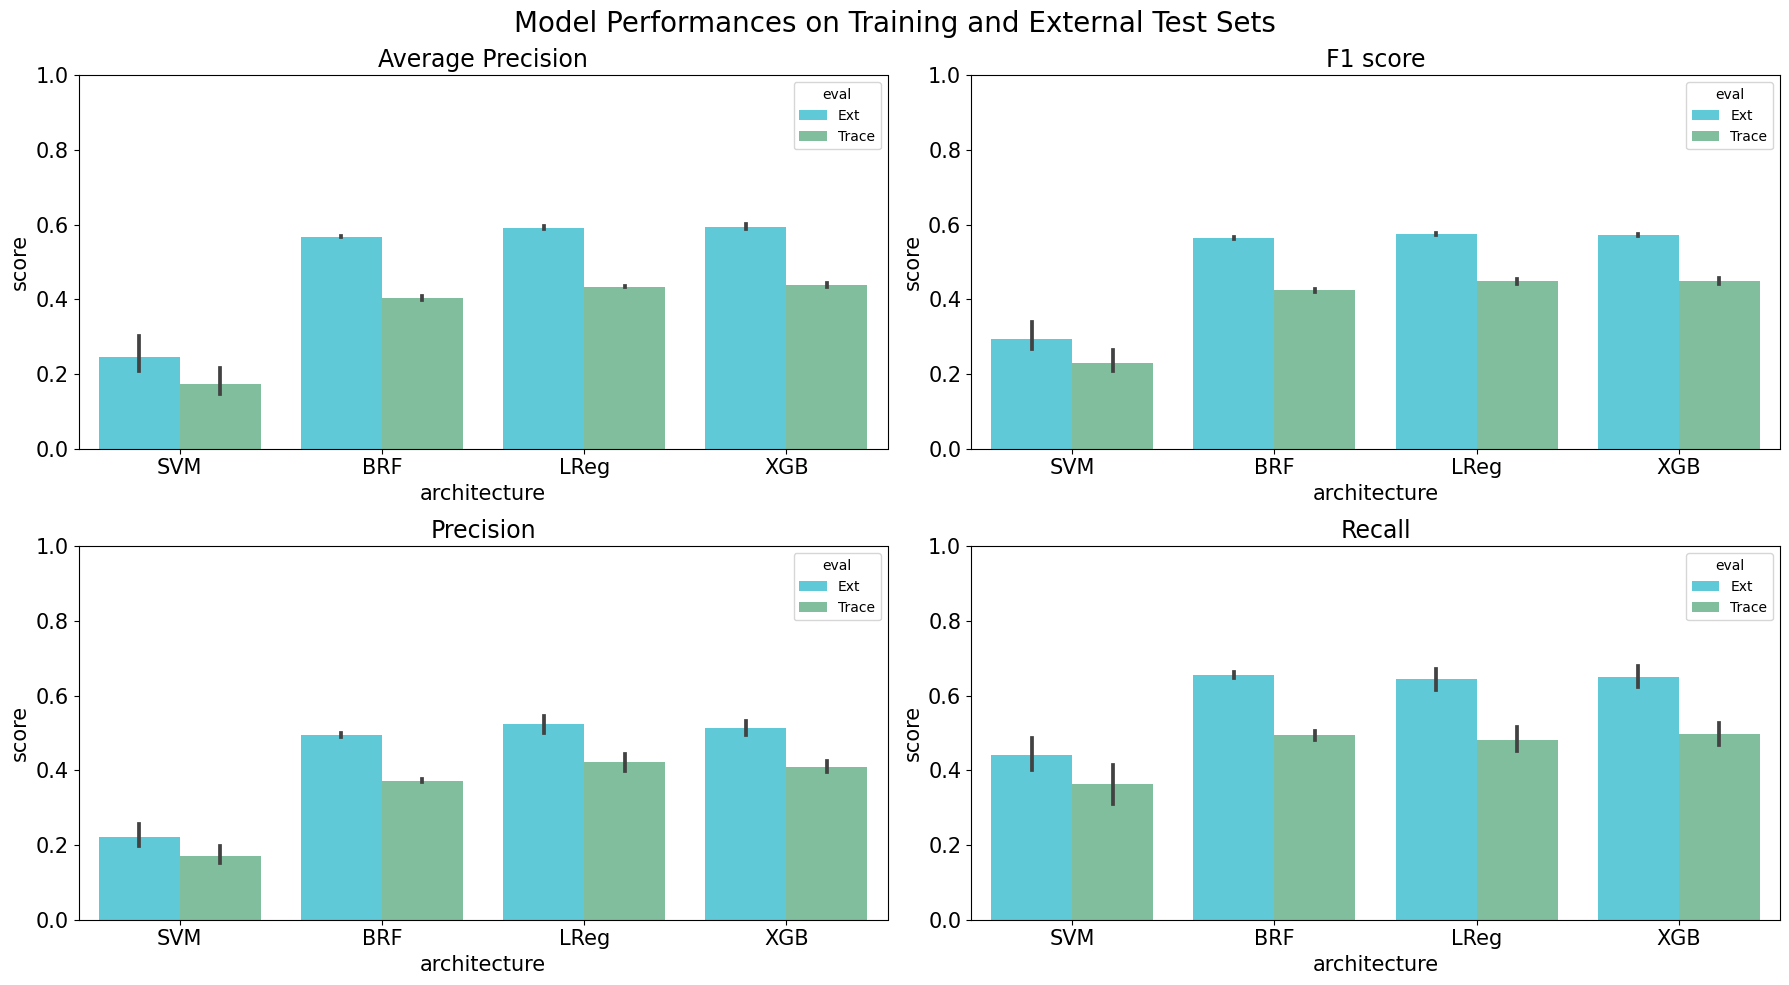

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(18,10))

titles = [['Average Precision', 'F1 score'], ['Precision', 'Recall']]
metrics = [['APR', 'F1'], ['PREC', 'RECALL']]
DF_TEMP = DF.query("eval != 'Train'")
for j in range(len(ax)):
    for i in range(len(ax[j])):
        DF_plot = DF_TEMP.loc[DF_TEMP.metric==metrics[j][i]].drop(['fold', 'metric'], axis=1)
        ax[j][i].tick_params(labelsize=15)
        ax[j][i].set_xlabel('model', fontsize=15, position=(.5,20))
        ax[j][i].set_ylim((0,1))
        ax[j][i].set_ylabel('score', fontsize=15)
        ax[j][i].set_title(titles[j][i], fontsize= 17)
        ax[j][i]=sns.barplot(data=DF_plot, x='architecture', y='score',
            dodge=True, hue='eval', palette=[colors.BLUE_SKY_CRAYOLA.value, colors.GREEN_SEA.value], alpha=0.7, ax=ax[j][i])
fig.suptitle('Model Performances on Training and External Test Sets', fontsize=20)
fig.tight_layout()
plt.show()

### Select best performing model by `APR` and save for further analysis

In [ ]:
arch='XGB' # set as 'XGB' or 'LReg'

In [26]:
apr_train = [average_precision_score(targets, models[arch][i]["model"].predict_proba(trainData)[:,1])for i in range(OuterFolds)]
apr_ext = [average_precision_score(y_ext, models[arch][i]["model"].predict_proba(X_ext)[:,1])for i in range(OuterFolds)]
apr_trace = [average_precision_score(y_trace, models[arch][i]["model"].predict_proba(X_trace)[:,1])for i in range(OuterFolds)]


f1_train = scoring(models=models[arch],
                data=trainData,
                ground=targets,
                score_func=f1_score)
f1_ext = scoring(models=models[arch],
                data=X_ext,
                ground=y_ext,
                score_func=f1_score)
f1_trace = scoring(models=models[arch],
                data=X_trace,
                ground=y_trace,
                score_func=f1_score)

prec_train = scoring(models=models[arch],
                data=trainData,
                ground=targets,
                score_func=precision_score)
prec_ext = scoring(models=models[arch],
                data=X_ext,
                ground=y_ext,
                score_func=precision_score)
prec_trace = scoring(models=models[arch],
                data=X_trace,
                ground=y_trace,
                score_func=precision_score)

recall_train = scoring(models=models[arch],
                data=trainData,
                ground=targets,
                score_func=recall_score)
recall_ext = scoring(models=models[arch],
                data=X_ext,
                ground=y_ext,
                score_func=recall_score)
recall_trace = scoring(models=models[arch],
                data=X_trace,
                ground=y_trace,
                score_func=recall_score)

apr_drop = (np.array(apr_ext)-np.array(apr_trace))*100
f1_drop = (np.array(f1_ext)-np.array(f1_trace))*100
prec_drop = (np.array(prec_ext)-np.array(prec_trace))*100
recall_drop = (np.array(recall_ext)-np.array(recall_trace))*100

brier_ext = [brier_score_loss(y_ext, models[arch][i]["model"].predict_proba(X_ext)[:,1])for i in range(OuterFolds)]
brier_trace = [brier_score_loss(y_trace, models[arch][i]["model"].predict_proba(X_trace)[:,1])for i in range(OuterFolds)]
brier_drop = (np.array(brier_trace)-np.array(brier_ext))*100


Select and save best performing model

In [30]:
best_model = models[arch][np.argmax(apr_train)]
best_feats = [featureDict[col] for col in trainData.iloc[:,best_model['features']].columns]

probs = best_model['model'].predict_proba(X_ext)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)
print(classification_report(y_true=y_ext,
                        y_pred=preds))

with open(f"models/best_model{norm_tag}_{arch}", "wb") as fp:
    pickle.dump(best_model, fp)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     10982
           1       0.49      0.68      0.57      1033

    accuracy                           0.91     12015
   macro avg       0.73      0.81      0.76     12015
weighted avg       0.93      0.91      0.92     12015



Check input feature subspace for selected best model

In [31]:
print(best_feats)
with open("best_features", "wb") as fp:
    pickle.dump(best_feats, fp)

['waistcircum', 'hipcircum', 'bmi', 'weight', 'wholebodywatermass', 'basalmetabolicrate', 'birthyear', 'employed', 'retired', 'unabletowork', 'noeducation', 'napduringday', 'nodietchange', 'yesilldietchange', 'freqtiredness2weeks']
